In [1]:
import torch
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

In [2]:
class ProductSearchDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.data = dataset
    
    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):
        row = self.data.iloc[index]

        # Extract data
        product_id = row['id']
        product_desc = row['description']
        product_cluster = row['label']
        
        # Get all queries
        product_queries = row[['query_1', 'query_2', 'query_3', 'query_4', 'query_5']].values
    
        # Randomly select one query for training
        query = np.random.choice(product_queries)
    
        return query, product_desc, product_id, product_cluster

In [3]:
df = pd.read_csv('data/home_products_with_sample_queries')

In [4]:
df.head()

,id,title,description,label,query_1,query_2,query_3,query_4,query_5
0,B0BFJL5LD1,VGYVGYCC Outdoor Solar Garden Lights - 2 Pack ...,2022 Newest Version2 pack solar tulip lights a...,12,Large decorative solar lights,Easy to install garden lights,Waterproof outdoor tulip lights,Gift idea for garden decor,High-quality solar tulip lights
1,B0002H49E4,LEATHERMAN - Standard Nylon Sheath with Pocket...,Product Description This nylon belt sheath is ...,55,Sturdy nylon belt sheath,Sheath for Leatherman Wave,Multitool sheath with pockets,Durable vertical carry sheath,Leatherman Wave belt sheath
2,B084GYHQFY,"Makita MAC210Q Quiet Series, 1 HP, 2 Gallon, O...",Compressors are workhorse tools on the job sit...,31,Makita quiet air compressor,Portable electric air compressor,Lightweight 2-gallon compressor,Oil-free electric compressor,Low-noise air compressor
3,B09ZP7M7R1,"Greenclick Landscape Lighting, 3W 12V Extendab...",Safe Low Voltage Landscape LightsLow voltage l...,35,Safe low voltage landscape lights,Extendable garden spotlights,Bright outdoor Christmas lights,Waterproof garden spotlights,Landscape lighting set with transformer
4,B0BRGRNK2H,20 oz Big Gap Filler Insulating Foam Sealant (...,Product Description GREAT STUFF Big Gap Filler...,8,Big gap filler foam sealant,Insulating foam for large gaps,Airtight sealant for drafts,Paintable foam insulation,Weather-tight foam sealant


In [5]:
train_dataset, val_dataset = train_test_split(df, test_size=0.2, random_state=3478)
train_dataset.reset_index(drop=True, inplace=True)
val_dataset.reset_index(drop=True, inplace=True)

In [6]:
class QueryEncoder(torch.nn.Module):
    def __init__(self, vocab_size, embed_dim, output_embed_dim):
        super().__init__()
        self.embedding_layer = torch.nn.Embedding(vocab_size, embed_dim)
        # Use fewer transformer layers for queries since they're shorter
        self.encoder = torch.nn.TransformerEncoder(
            torch.nn.TransformerEncoderLayer(embed_dim, nhead=8, batch_first=True),
            num_layers=2,
            norm=torch.nn.LayerNorm([embed_dim]),
            enable_nested_tensor=False
        )
        self.projection = torch.nn.Linear(embed_dim, output_embed_dim)
        
    def forward(self, tokenizer_output):
        # Move inputs to the same device as the model
        input_ids = tokenizer_output['input_ids'].to(self.embedding_layer.weight.device)
        attention_mask = tokenizer_output['attention_mask'].to(self.embedding_layer.weight.device)
        
        x = self.embedding_layer(input_ids)
        x = self.encoder(x, src_key_padding_mask=attention_mask.logical_not())
        # Use mean pooling instead of CLS token for queries
        # This helps capture information from all tokens in short queries
        mask_expanded = attention_mask.unsqueeze(-1).expand(x.size())
        sum_embeddings = torch.sum(x * mask_expanded, 1)
        sum_mask = torch.sum(mask_expanded, 1)
        mean_embeddings = sum_embeddings / sum_mask
        return self.projection(mean_embeddings)

In [7]:
class ProductEncoder(torch.nn.Module):
    def __init__(self, vocab_size, embed_dim, output_embed_dim):
        super().__init__()
        self.embedding_layer = torch.nn.Embedding(vocab_size, embed_dim)
        # Use more transformer layers for product descriptions since they're longer
        self.encoder = torch.nn.TransformerEncoder(
            torch.nn.TransformerEncoderLayer(embed_dim, nhead=8, batch_first=True),
            num_layers=4,
            norm=torch.nn.LayerNorm([embed_dim]),
            enable_nested_tensor=False
        )
        self.projection = torch.nn.Linear(embed_dim, output_embed_dim)
        
    def forward(self, tokenizer_output):
        # Move inputs to the same device as the model
        input_ids = tokenizer_output['input_ids'].to(self.embedding_layer.weight.device)
        attention_mask = tokenizer_output['attention_mask'].to(self.embedding_layer.weight.device)
        
        x = self.embedding_layer(input_ids)
        x = self.encoder(x, src_key_padding_mask=attention_mask.logical_not())
        # Use CLS token for product descriptions
        cls_embed = x[:,0,:]
        return self.projection(cls_embed)

In [8]:
def batch_hard_negative_sampling(product_ids, cluster_ids, product_embeddings, num_negatives=1):
    """
    Sample hard negatives from the current batch, ensuring negatives come from different clusters.

    Args:
        product_ids (list): List of product IDs in the batch.
        cluster_ids (list): List of corresponding cluster IDs in the batch.
        product_embeddings (torch.Tensor): Tensor of product embeddings in the batch [batch_size, embed_dim].
        num_negatives (int): Number of negatives per query.

    Returns:
        neg_embeddings (torch.Tensor): Tensor of hard negative product embeddings [batch_size, num_negatives, embed_dim].
    """
    batch_size = len(product_ids)
    neg_samples = []

    for i in range(batch_size):
        # Get current cluster ID
        current_cluster = cluster_ids[i]

        # Find indices of products in the batch from a different cluster
        negative_indices = [j for j in range(batch_size) if cluster_ids[j] != current_cluster]

        # Sample negatives
        sampled_negatives = random.sample(negative_indices, num_negatives)
        
        # Store their embeddings
        neg_samples.append(product_embeddings[sampled_negatives])

    # Stack negatives into a tensor [batch_size, num_negatives, embed_dim]
    neg_embeddings = torch.stack(neg_samples).to(product_embeddings.device)
    
    return neg_embeddings

In [9]:
def evaluate_model(query_encoder, product_encoder, eval_dataset, tokenizer, query_max_len, product_max_len, k=10, device='cuda'):
    """
    Evaluate the model on the evaluation dataset
    
    Args:
        query_encoder: Query encoder model
        product_encoder: Product encoder model
        eval_dataset: Evaluation dataset
        tokenizer: Tokenizer
        query_max_len: Maximum query length
        product_max_len: Maximum product description length
        k: Number of top results to consider for metrics
        device: Device to use for computations
    """
    query_encoder.eval()
    product_encoder.eval()
    
    # Create evaluation dataloader
    eval_dataloader = torch.utils.data.DataLoader(eval_dataset, batch_size=8, shuffle=False)
    
    # First pass: encode all products
    all_product_ids = []
    all_product_embeddings = []
    
    with torch.no_grad():
        for batch_data in tqdm(eval_dataloader, desc="Encoding Products"):
            _, product_descs, product_ids, _ = batch_data
            
            product_tokens = tokenizer(
                product_descs, 
                padding=True, 
                truncation=True, 
                return_tensors="pt", 
                max_length=product_max_len
            )
            
            product_embeddings = product_encoder(product_tokens)
            product_embeddings = torch.nn.functional.normalize(product_embeddings, p=2, dim=1)
            
            all_product_ids.extend(product_ids)
            all_product_embeddings.append(product_embeddings.cpu())  # Move to CPU to save GPU memory
    
    # Concatenate all product embeddings
    all_product_embeddings = torch.cat(all_product_embeddings, dim=0)
    
    # Second pass: evaluate queries
    total_queries = 0
    hits_at_k = 0
    mrr = 0.0  # Mean Reciprocal Rank
    
    with torch.no_grad():
        for batch_data in tqdm(eval_dataloader, desc="Evaluating Queries"):
            queries, _, product_ids, _ = batch_data
            
            query_tokens = tokenizer(
                queries, 
                padding=True, 
                truncation=True, 
                return_tensors="pt", 
                max_length=query_max_len
            )
            
            query_embeddings = query_encoder(query_tokens)
            query_embeddings = torch.nn.functional.normalize(query_embeddings, p=2, dim=1)
            
            # Move query embeddings to CPU for comparison with all products
            query_embeddings_cpu = query_embeddings.cpu()
            
            # Compute similarities with all products
            similarities = query_embeddings_cpu @ all_product_embeddings.T
            
            # Get top-k indices
            _, top_indices = torch.topk(similarities, k=k, dim=1)
            
            # Convert to list for evaluation
            for i, (query_id, true_product_id) in enumerate(zip(range(len(queries)), product_ids)):
                total_queries += 1
                top_k_product_ids = [all_product_ids[idx] for idx in top_indices[i].tolist()]
                
                # Check if true product is in top-k
                if true_product_id in top_k_product_ids:
                    hits_at_k += 1
                    # Calculate reciprocal rank
                    rank = top_k_product_ids.index(true_product_id) + 1
                    mrr += 1.0 / rank
    
    # Calculate metrics
    hits_at_k_rate = hits_at_k / total_queries if total_queries > 0 else 0
    mrr = mrr / total_queries if total_queries > 0 else 0
    
    print(f"Evaluation Metrics:")
    print(f"Hits@{k}: {hits_at_k_rate:.4f}")
    print(f"MRR: {mrr:.4f}")

    return hits_at_k_rate, mrr

In [10]:
def in_batch_negative_sampling_loss(query_embeddings, product_embeddings, negative_embeddings, temperature=0.1):
    """
    Compute in-batch negative sampling loss (InfoNCE loss) with hard negatives.

    Args:
        query_embeddings: Query embeddings [batch_size, embed_dim]
        product_embeddings: Product embeddings [batch_size, embed_dim]
        negative_embeddings: Hard negative product embeddings [batch_size, embed_dim]
        temperature: Temperature parameter for softmax.

    Returns:
        loss: InfoNCE loss
    """
    batch_size = query_embeddings.shape[0]

    # Squeeze negative embeddings to remove the unnecessary dimension
    negative_embeddings = negative_embeddings.squeeze(1)

    # Compute similarity scores
    positive_sim = (query_embeddings * product_embeddings).sum(dim=1) / temperature
    negative_sim = (query_embeddings @ negative_embeddings.T) / temperature  # Hard negatives

    # Stack positives and negatives
    logits = torch.cat([positive_sim.unsqueeze(1), negative_sim], dim=1)

    # Labels: First column (positive pair) is correct
    labels = torch.zeros(batch_size, dtype=torch.long, device=query_embeddings.device)

    # Compute loss
    loss = torch.nn.functional.cross_entropy(logits, labels)

    return loss

In [11]:
def train_embedding_model(dataset, num_epochs=10, learning_rate=1e-4, eval_dataset=None, patience=10):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    dataset = ProductSearchDataset(dataset)
    eval_dataset = ProductSearchDataset(eval_dataset)

    embed_size = 512
    output_embed_size = 128
    query_max_len = 32
    product_max_len = 512
    batch_size = 8

    tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

    # Initialize encoders
    query_encoder = QueryEncoder(vocab_size=tokenizer.vocab_size, embed_dim=embed_size, output_embed_dim=output_embed_size).to(device)
    product_encoder = ProductEncoder(vocab_size=tokenizer.vocab_size, embed_dim=embed_size, output_embed_dim=output_embed_size).to(device)

    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.Adam(list(query_encoder.parameters()) + list(product_encoder.parameters()), lr=learning_rate)

    scaler = torch.amp.GradScaler(device)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

    total_steps = len(dataloader) * num_epochs
    main_progress_bar = tqdm(total=total_steps, desc="Training Progress", position=0)

    best_hits = 0
    patience_counter = 0
    best_query_encoder_weights = None
    best_product_encoder_weights = None

    
    hits_log = []
    mrr_log = []
    
    for epoch in range(num_epochs):
        # Early stopping check
        if patience_counter == patience:
            break
        
        query_encoder.train()
        product_encoder.train()
        epoch_loss = []

        epoch_desc = f"Epoch {epoch+1}/{num_epochs}"
        epoch_progress = tqdm(dataloader, desc=epoch_desc, leave=False, position=1)

        for batch_idx, batch_data in enumerate(epoch_progress):
            queries, product_descs, product_ids, cluster_ids = batch_data

            query_tokens = tokenizer(queries, padding=True, truncation=True, return_tensors="pt", max_length=query_max_len).to(device)
            product_tokens = tokenizer(product_descs, padding=True, truncation=True, return_tensors="pt", max_length=product_max_len).to(device)

            with torch.amp.autocast(device.type):
                query_embeddings = query_encoder(query_tokens)
                product_embeddings = product_encoder(product_tokens)

                query_embeddings = torch.nn.functional.normalize(query_embeddings, p=2, dim=1)
                product_embeddings = torch.nn.functional.normalize(product_embeddings, p=2, dim=1)

                # Get hard negatives from the batch
                negative_embeddings = batch_hard_negative_sampling(product_ids, cluster_ids, product_embeddings, num_negatives=1)

                loss = in_batch_negative_sampling_loss(query_embeddings, product_embeddings, negative_embeddings)

            epoch_loss.append(loss.item())

            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            main_progress_bar.update(1)
            epoch_progress.set_postfix({"loss": f"{loss.item():.4f}"})

        avg_loss = np.mean(epoch_loss)
        print(f"\nEpoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")

        scheduler.step(avg_loss)

        if eval_dataset is not None:
            print("\nEvaluating model...")
            hits_in_top_k, mrr = evaluate_model(query_encoder, product_encoder, eval_dataset, tokenizer, query_max_len, product_max_len, device=device)
            if hits_in_top_k > best_hits:
                best_hits = hits_in_top_k
                best_query_encoder_weights = query_encoder.state_dict()
                best_product_encoder_weights = product_encoder.state_dict()
                patience_counter = 0
            else:
                patience_counter += 1
            hits_log.append(hits_in_top_k)
            mrr_log.append(mrr)

    main_progress_bar.close()

    # Load the model weights with the best validation hits
    query_encoder.load_state_dict(best_query_encoder_weights)
    product_encoder.load_state_dict(best_product_encoder_weights)

    return query_encoder, product_encoder, hits_log, mrr_log

In [12]:
query_encoder, product_encoder, hits_in_top_k_history, mrr_history = train_embedding_model(train_dataset, num_epochs=100, eval_dataset=val_dataset, patience=10)

Using device: cuda


Training Progress:   0%|          | 0/3000 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch 1/100, Average Loss: 2.1792

Evaluating model...


Encoding Products:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.1695
MRR: 0.0485


Epoch 2/100:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch 2/100, Average Loss: 2.1781

Evaluating model...


Encoding Products:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.1864
MRR: 0.0515


Epoch 3/100:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch 3/100, Average Loss: 2.1860

Evaluating model...


Encoding Products:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.2203
MRR: 0.0548


Epoch 4/100:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch 4/100, Average Loss: 2.1616

Evaluating model...


Encoding Products:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.2881
MRR: 0.0972


Epoch 5/100:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch 5/100, Average Loss: 2.0728

Evaluating model...


Encoding Products:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.3220
MRR: 0.1063


Epoch 6/100:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch 6/100, Average Loss: 2.0545

Evaluating model...


Encoding Products:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.3220
MRR: 0.1039


Epoch 7/100:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch 7/100, Average Loss: 1.9718

Evaluating model...


Encoding Products:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.3220
MRR: 0.1109


Epoch 8/100:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch 8/100, Average Loss: 1.9385

Evaluating model...


Encoding Products:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.3220
MRR: 0.1039


Epoch 9/100:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch 9/100, Average Loss: 1.8055

Evaluating model...


Encoding Products:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.2881
MRR: 0.0732


Epoch 10/100:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch 10/100, Average Loss: 1.7565

Evaluating model...


Encoding Products:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.4068
MRR: 0.1207


Epoch 11/100:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch 11/100, Average Loss: 1.8054

Evaluating model...


Encoding Products:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.4237
MRR: 0.1397


Epoch 12/100:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch 12/100, Average Loss: 1.7210

Evaluating model...


Encoding Products:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.3729
MRR: 0.1242


Epoch 13/100:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch 13/100, Average Loss: 1.6305

Evaluating model...


Encoding Products:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.3390
MRR: 0.1008


Epoch 14/100:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch 14/100, Average Loss: 1.5765

Evaluating model...


Encoding Products:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.4746
MRR: 0.1702


Epoch 15/100:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch 15/100, Average Loss: 1.6316

Evaluating model...


Encoding Products:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.4407
MRR: 0.1458


Epoch 16/100:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch 16/100, Average Loss: 1.5170

Evaluating model...


Encoding Products:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.4407
MRR: 0.1641


Epoch 17/100:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch 17/100, Average Loss: 1.5375

Evaluating model...


Encoding Products:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.4068
MRR: 0.1482


Epoch 18/100:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch 18/100, Average Loss: 1.4093

Evaluating model...


Encoding Products:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.4237
MRR: 0.1625


Epoch 19/100:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch 19/100, Average Loss: 1.3547

Evaluating model...


Encoding Products:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.5763
MRR: 0.2208


Epoch 20/100:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch 20/100, Average Loss: 1.2796

Evaluating model...


Encoding Products:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.4746
MRR: 0.1972


Epoch 21/100:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch 21/100, Average Loss: 1.2158

Evaluating model...


Encoding Products:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.5424
MRR: 0.2145


Epoch 22/100:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch 22/100, Average Loss: 1.2073

Evaluating model...


Encoding Products:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.4746
MRR: 0.1591


Epoch 23/100:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch 23/100, Average Loss: 1.2485

Evaluating model...


Encoding Products:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.4746
MRR: 0.1751


Epoch 24/100:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch 24/100, Average Loss: 1.2241

Evaluating model...


Encoding Products:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.5085
MRR: 0.1764


Epoch 25/100:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch 25/100, Average Loss: 1.0704

Evaluating model...


Encoding Products:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.5593
MRR: 0.2097


Epoch 26/100:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch 26/100, Average Loss: 1.1427

Evaluating model...


Encoding Products:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.5593
MRR: 0.2099


Epoch 27/100:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch 27/100, Average Loss: 1.1244

Evaluating model...


Encoding Products:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.5424
MRR: 0.2316


Epoch 28/100:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch 28/100, Average Loss: 1.1052

Evaluating model...


Encoding Products:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.5932
MRR: 0.2174


Epoch 29/100:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch 29/100, Average Loss: 1.0369

Evaluating model...


Encoding Products:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.4576
MRR: 0.1858


Epoch 30/100:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch 30/100, Average Loss: 0.9718

Evaluating model...


Encoding Products:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.5593
MRR: 0.1709


Epoch 31/100:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch 31/100, Average Loss: 0.9154

Evaluating model...


Encoding Products:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.5763
MRR: 0.2414


Epoch 32/100:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch 32/100, Average Loss: 0.8900

Evaluating model...


Encoding Products:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.5932
MRR: 0.2309


Epoch 33/100:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch 33/100, Average Loss: 0.9213

Evaluating model...


Encoding Products:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.5763
MRR: 0.2125


Epoch 34/100:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch 34/100, Average Loss: 0.8977

Evaluating model...


Encoding Products:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.5932
MRR: 0.2356


Epoch 35/100:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch 35/100, Average Loss: 0.8145

Evaluating model...


Encoding Products:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.6441
MRR: 0.3154


Epoch 36/100:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch 36/100, Average Loss: 0.8518

Evaluating model...


Encoding Products:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.6780
MRR: 0.2771


Epoch 37/100:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch 37/100, Average Loss: 0.8078

Evaluating model...


Encoding Products:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.6441
MRR: 0.2550


Epoch 38/100:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch 38/100, Average Loss: 0.8206

Evaluating model...


Encoding Products:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.5763
MRR: 0.2656


Epoch 39/100:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch 39/100, Average Loss: 0.8148

Evaluating model...


Encoding Products:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.5932
MRR: 0.2613


Epoch 40/100:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch 40/100, Average Loss: 0.8490

Evaluating model...


Encoding Products:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.7288
MRR: 0.3296


Epoch 41/100:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch 41/100, Average Loss: 0.7591

Evaluating model...


Encoding Products:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.6610
MRR: 0.2623


Epoch 42/100:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch 42/100, Average Loss: 0.7509

Evaluating model...


Encoding Products:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.6441
MRR: 0.3274


Epoch 43/100:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch 43/100, Average Loss: 0.7773

Evaluating model...


Encoding Products:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.6102
MRR: 0.2857


Epoch 44/100:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch 44/100, Average Loss: 0.7328

Evaluating model...


Encoding Products:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.5763
MRR: 0.2681


Epoch 45/100:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch 45/100, Average Loss: 0.7245

Evaluating model...


Encoding Products:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.6949
MRR: 0.2656


Epoch 46/100:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch 46/100, Average Loss: 0.7296

Evaluating model...


Encoding Products:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.5763
MRR: 0.2234


Epoch 47/100:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch 47/100, Average Loss: 0.7368

Evaluating model...


Encoding Products:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.5254
MRR: 0.2543


Epoch 48/100:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch 48/100, Average Loss: 0.7319

Evaluating model...


Encoding Products:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.5763
MRR: 0.2599


Epoch 49/100:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch 49/100, Average Loss: 0.7331

Evaluating model...


Encoding Products:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.5763
MRR: 0.2965


Epoch 50/100:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch 50/100, Average Loss: 0.7597

Evaluating model...


Encoding Products:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.6271
MRR: 0.2644


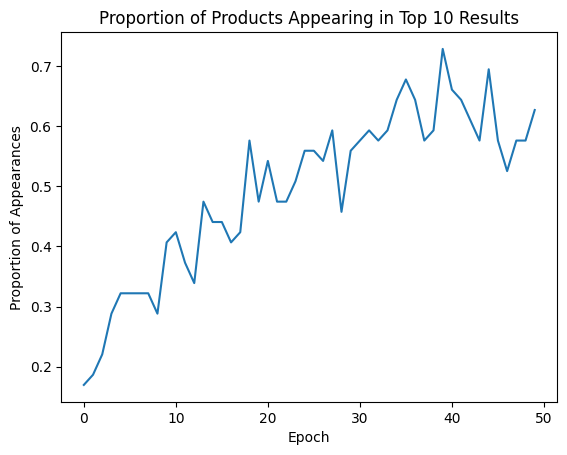

In [13]:
plt.plot(hits_in_top_k_history)
plt.xlabel("Epoch")
plt.ylabel("Proportion of Appearances")
plt.title("Proportion of Products Appearing in Top 10 Results")
plt.show()

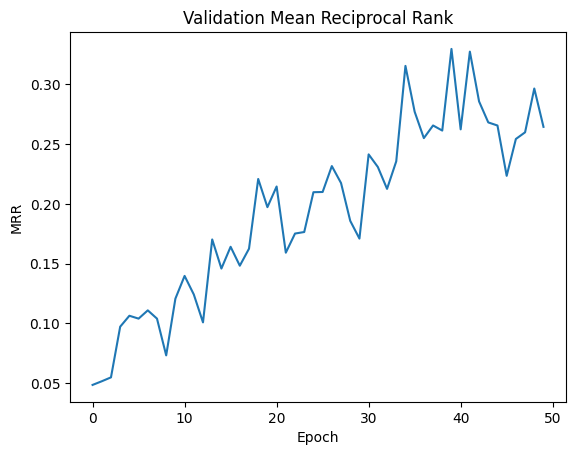

In [14]:
plt.plot(mrr_history)
plt.xlabel("Epoch")
plt.ylabel("MRR")
plt.title("Validation Mean Reciprocal Rank")
plt.show()

In [15]:
# Save models
torch.save(query_encoder.state_dict(), 'data/home_products_query_encoder_v3.pt')
torch.save(product_encoder.state_dict(), 'data/home_products_description_encoder_v3.pt')